In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 드라이브의 zip 파일을 Colab 로컬 저장소로 복사
!cp /content/drive/MyDrive/DCC2025/Data/Training/01.원천데이터/TS_SN10_SN10.zip /content/
!cp /content/drive/MyDrive/DCC2025/Data/Training/02.라벨링데이터/TL_SN10.zip /content/
!cp /content/drive/MyDrive/DCC2025/Data/Validation/01.원천데이터/VS_SN10_SN10.zip /content
!cp /content/drive/MyDrive/DCC2025/Data/Validation/02.라벨링데이터/VL_SN10.zip /content/

# 압축 해제
!unzip /content/TS_SN10_SN10.zip -d /content/TS_SN10_SN10
!unzip /content/TL_SN10.zip -d /content/TL_SN10
!unzip /content/VS_SN10_SN10.zip -d /content/VS_SN10_SN10
!unzip /content/VL_SN10.zip -d /content/VL_SN10

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/TL_SN10/SN10_KOR_01402_230409.tif  
  inflating: /content/TL_SN10/SN10_KOR_01421_230409.tif  
  inflating: /content/TL_SN10/SN10_KOR_01434_230409.tif  
  inflating: /content/TL_SN10/SN10_KOR_01391_240612.tif  
  inflating: /content/TL_SN10/SN10_KOR_01379_240612.tif  
  inflating: /content/TL_SN10/SN10_KOR_01411_230409.tif  
  inflating: /content/TL_SN10/SN10_KOR_01398_230409.tif  
  inflating: /content/TL_SN10/SN10_KOR_01521_231031.tif  
  inflating: /content/TL_SN10/SN10_KOR_01437_230409.tif  
  inflating: /content/TL_SN10/SN10_KOR_01432_230409.tif  
  inflating: /content/TL_SN10/SN10_KOR_01463_230509.tif  
  inflating: /content/TL_SN10/SN10_KOR_01406_230409.tif  
  inflating: /content/TL_SN10/SN10_KOR_01436_230409.tif  
  inflating: /content/TL_SN10/SN10_KOR_01419_230409.tif  
  inflating: /content/TL_SN10/SN10_KOR_01407_230409.tif  
  inflating: /content/TL_SN10/SN10_KOR_01404_230409.tif  
  inflating: /content/TL_SN10/SN10_K

In [3]:
!nvidia-smi

Tue Oct 14 01:26:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   39C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Import packages

In [4]:
!pip install segmentation-models-pytorch==0.3.3 timm==0.9.2

import os
import cv2
import csv
import numpy as np
import torch, torch.nn as nn
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
import albumentations as A
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import random
import torch.nn.functional as F
import timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 101.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=b4046e8891db875ed4773d76844c7daf524411d1c830a317960e4e141b333b91
  Stored in directory: /root/.cache/pip/wheels/9c/3f/43/e6271c7026fe08c185da2be23c98c8e87477d3db63f41f32ad
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=32ca7e3001faf9cfdefe8680b3a62f47638fb36c68d4aae7125e69aafb6adcb2
  Stored in directory: /root/.cache/pip/wheels/4c/01/56/40a48f75dbdfe167a0cb70d3b48913369a00ec5c4e9fed5f2b
Successfully built efficientnet-pytor

### seed 고정 (42)

In [5]:
# ===== set seed for reproducing =====
def set_global_seed(seed):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    import torch.backends.cudnn as cudnn
    cudnn.benchmark = False
    cudnn.deterministic = True
    torch.backends.cuda.matmul.allow_tf32 = False
    cudnn.allow_tf32 = False
    torch.use_deterministic_algorithms(True, warn_only=True)

## Dataset

*.tif 이미지를 png 이미지로 변환 후 저장

**Training**

In [6]:
!pip install rasterio
import glob
import rasterio

# ===== Function definition ====
def normalize(a: np.ndarray) -> np.ndarray:
    """0~1 정규화"""
    a = a.astype(np.float32)
    mn, mx = np.nanmin(a), np.nanmax(a)
    if mx == mn:
        return np.zeros_like(a, dtype=np.float32)
    return (a - mn) / (mx - mn)


# ===== Folder path =====
base_dir = "/content/TS_SN10_SN10"
save_rgbnir = os.path.join(base_dir,"RGBNIR")

os.makedirs(save_rgbnir, exist_ok=True)

b_visualization = False     # for checking converted image

# check the size of *.tif
tif_list = sorted(glob.glob(os.path.join(base_dir, "*.tif")))
print(f"Found {len(tif_list)} tif files.")

# ===== Image dataset generation =====
'''
Convert *.tif to *.jpg
'''
for tif_pth in tif_list:
    fname = os.path.splitext(os.path.basename(tif_pth))[0]

    with rasterio.open(tif_pth) as src:
        RED   = src.read(1)
        GREEN = src.read(2)
        BLUE  = src.read(3)
        NIR   = src.read(4)


    rgb = np.dstack([normalize(RED), normalize(GREEN), normalize(BLUE)])
    fc = np.dstack([normalize(NIR), normalize(RED), normalize(GREEN)])
    rgbnir = np.dstack([normalize(RED), normalize(GREEN), normalize(BLUE), normalize(NIR)])

    if b_visualization: # only visualization
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(rgb)
        axes[0].set_title("RGB")
        axes[0].axis("off")

        axes[1].imshow(fc)
        axes[1].set_title("False Color (NIR-R-G)")
        axes[1].axis("off")

        axes[2].imshow(rgbnir)
        axes[2].set_title("RGB + NIR")
        axes[2].axis("off")

        plt.suptitle(fname)
        plt.tight_layout()
        plt.show()

    else:   # only convertation
        if os.path.isfile(os.path.join(save_rgbnir,fname + ".png")):
            continue
        plt.imsave(os.path.join(save_rgbnir,fname + ".png"),rgbnir)

print("dataset generation finished")

# ===== Folder path =====
mask_dir = "/content/TL_SN10"
save_mask = "/content/TL_SN10/masks_png"
os.makedirs(save_mask, exist_ok=True)

tif_list = sorted(glob.glob(os.path.join(mask_dir, "*.tif")))
print(f"Found {len(tif_list)} mask files.")

# ===== Label dataset generation =====
for tif_pth in tif_list:
    fname = os.path.splitext(os.path.basename(tif_pth))[0]

    with rasterio.open(tif_pth) as src:
        mask = src.read(1).astype(np.uint8)

    mask_remap = np.zeros_like(mask, dtype=np.uint8)
    mask_remap[mask == 10] = 1  # 산업단지
    mask_remap[mask == 90] = 0

    cv2.imwrite(os.path.join(save_mask, fname + ".png"), mask_remap * 255)

print("dataset(label) generation finished")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 102.9 MB/s eta 0:00:00
Found 8000 tif files.


/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


dataset generation finished
Found 8000 mask files.
dataset(label) generation finished


**Validation**

In [7]:
# ===== Folder path =====
base_dir = "/content/VS_SN10_SN10"
save_rgbnir = os.path.join(base_dir,"RGBNIR")

os.makedirs(save_rgbnir, exist_ok=True)

b_visualization = False     # for checking converted image

# check the size of *.tif
tif_list = sorted(glob.glob(os.path.join(base_dir, "*.tif")))
print(f"Found {len(tif_list)} tif files.")

# ===== Image dataset generation =====
'''
Convert *.tif to *.jpg
'''
for tif_pth in tif_list:
    fname = os.path.splitext(os.path.basename(tif_pth))[0]

    with rasterio.open(tif_pth) as src:
        RED   = src.read(1)
        GREEN = src.read(2)
        BLUE  = src.read(3)
        NIR   = src.read(4)

    rgb = np.dstack([normalize(RED), normalize(GREEN), normalize(BLUE)])
    fc = np.dstack([normalize(NIR), normalize(RED), normalize(GREEN)])
    rgbnir = np.dstack([normalize(RED), normalize(GREEN), normalize(BLUE), normalize(NIR)])

    if b_visualization: # only visualization
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(rgb)
        axes[0].set_title("RGB")
        axes[0].axis("off")

        axes[1].imshow(fc)
        axes[1].set_title("False Color (NIR-R-G)")
        axes[1].axis("off")

        axes[2].imshow(rgbnir)
        axes[2].set_title("RGB + NIR")
        axes[2].axis("off")

        plt.suptitle(fname)
        plt.tight_layout()
        plt.show()

    else:   # only convertation
        if os.path.isfile(os.path.join(save_rgbnir,fname + ".png")):
            continue
        plt.imsave(os.path.join(save_rgbnir,fname + ".png"),rgbnir)

print("dataset generation finished")

# ===== Folder path =====
mask_dir = "/content/VL_SN10"
save_mask = "/content/VL_SN10/masks_png"
os.makedirs(save_mask, exist_ok=True)

tif_list = sorted(glob.glob(os.path.join(mask_dir, "*.tif")))
print(f"Found {len(tif_list)} mask files.")

# ===== Label dataset generation =====
for tif_pth in tif_list:
    fname = os.path.splitext(os.path.basename(tif_pth))[0]

    with rasterio.open(tif_pth) as src:
        mask = src.read(1).astype(np.uint8)

    mask_remap = np.zeros_like(mask, dtype=np.uint8)
    mask_remap[mask == 10] = 1  # 산업단지
    mask_remap[mask == 90] = 0

    cv2.imwrite(os.path.join(save_mask, fname + ".png"), mask_remap * 255)

print("dataset(label) generation finished")

Found 1000 tif files.
dataset generation finished
Found 1000 mask files.
dataset(label) generation finished


**Dataloader**


RGBNIR 데이터를 불러와 RGB, NIR 데이터로 분리하여 Multi-stream U-Net의 Input으로 설정

In [8]:
# ===== Dataset =====
class SegDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.fnames = sorted(os.listdir(img_dir))
        self.transform = transform

    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.fnames[idx])
        mask_path = os.path.join(self.mask_dir, self.fnames[idx])
        mask_path = mask_path.replace(".jpg", ".png").replace("RGBNIR", "")
        image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)  # 4채널로 읽기
        b, g, r, nir = cv2.split(image)
        rgb = np.stack([r, g, b], axis=-1)  # RGB로 변환
        nir = nir
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = mask.astype(np.float32) / 255.0  # 0 or 1

        if self.transform:
            augmented_rgb = self.transform(image=rgb, mask=mask)
            rgb_tensor, mask_tensor = augmented_rgb["image"], augmented_rgb["mask"].unsqueeze(0)
            augmented_nir = self.transform(image=nir, mask=mask)
            nir_tensor = augmented_nir["image"]    # [1,H,W]
        else:
            rgb_tensor = torch.from_numpy(rgb.transpose(2,0,1)).float()
            nir_tensor = torch.from_numpy(nir).unsqueeze(0).float()
            mask_tensor = torch.from_numpy(mask).unsqueeze(0).float()

        return rgb_tensor, nir_tensor, mask_tensor

# 학습 환경 설정

Data Augmentation

In [9]:
# ===== Augmentation =====
train_transform = A.Compose([
    ToTensorV2()
], additional_targets={'nir': 'image'})

val_transform = A.Compose([
    ToTensorV2()
], additional_targets={'nir': 'image'})

CutMix 정의

In [10]:
def cutmix(rgb, nir, masks, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(rgb.size(0)).to(rgb.device)

    rgb_shuffled  = rgb[rand_index]
    nir_shuffled  = nir[rand_index]
    masks_shuffled= masks[rand_index]

    bbx1, bby1, bbx2, bby2 = rand_bbox(rgb.size(), lam)

    rgb[:, :, bby1:bby2, bbx1:bbx2]   = rgb_shuffled[:, :, bby1:bby2, bbx1:bbx2]
    nir[:, :, bby1:bby2, bbx1:bbx2]   = nir_shuffled[:, :, bby1:bby2, bbx1:bbx2]
    masks[:, :, bby1:bby2, bbx1:bbx2] = masks_shuffled[:, :, bby1:bby2, bbx1:bbx2]

    # 실제 lam은 잘린 영역 비율에 따라 다시 계산
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (rgb.size(-1) * rgb.size(-2)))
    return rgb, nir, masks, lam

def rand_bbox(size, lam):
    """lam 비율에 따라 박스 좌표 생성"""
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


**IoU 계산**

sigmoid 적용 후 threshold 0.5 기준으로 이진화하여 평가

In [11]:

def batch_iou_vec(preds, masks, thr=0.5):
    probs = torch.sigmoid(preds)
    pb = (probs > thr).float()
    mb = (masks > 0.5).float()

    B = pb.shape[0]
    pb = pb.view(B, -1)
    mb = mb.view(B, -1)

    inter = (pb * mb).sum(dim=1)
    union = pb.sum(dim=1) + mb.sum(dim=1) - inter
    iou = inter / (union + 1e-7)
    return iou.cpu()

**Dataloader**

In [12]:
set_global_seed(42)

# ===== DataLoader =====
train_img_pth = "/content/TS_SN10_SN10/RGBNIR"
train_mask_pth = "/content/TL_SN10/masks_png"

valid_img_pth = "/content/VS_SN10_SN10/RGBNIR"
valid_mask_pth = "/content/VL_SN10/masks_png"

train_dataset = SegDataset(train_img_pth, train_mask_pth, transform=train_transform)
val_dataset   = SegDataset(valid_img_pth, valid_mask_pth, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)

**Multi-stream U-Net 정의**

RGB Input은 ImageNet으로 사전 학습된 가중치를 사용
NIR Input은 사전 학습된 가중치 미사용

각각이 U-Net을 통과한 이후 마지막 Feature map을 concate 하여 최종 결과 도출


In [13]:
class MultiStreamUNet(nn.Module):
    def __init__(self, encoder_name="resnet50"):
        super().__init__()
        # RGB stream (pretrained ImageNet)
        self.unet_rgb = smp.Unet(encoder_name, encoder_weights="imagenet", in_channels=3, classes=1)
        # NIR stream (1채널, random init)
        self.unet_nir = smp.Unet(encoder_name, encoder_weights=None, in_channels=1, classes=1)
        # 최종 결합 conv
        self.final_conv = nn.Conv2d(2, 1, kernel_size=1)

    def forward(self, rgb, nir):
        out_rgb = self.unet_rgb(rgb)   # [B,1,H,W]
        out_nir = self.unet_nir(nir)   # [B,1,H,W]
        out = torch.cat([out_rgb, out_nir], dim=1)  # [B,2,H,W]
        out = self.final_conv(out)  # [B,1,H,W]
        return out

In [14]:
model = MultiStreamUNet("resnet50")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 269MB/s]


**Loss & Optimizer 정의**

In [15]:
# ===== Loss & Optimizer =====
dice_loss = smp.losses.DiceLoss("binary")
bce_loss  = smp.losses.SoftBCEWithLogitsLoss()

EPOCHS = 50
def loss_fn(preds, targets):
    return dice_loss(preds, targets)  + bce_loss(preds,targets)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=EPOCHS, eta_min=1e-6
)

학습 과정 및 결과 분석을 위한 CSV 생성

In [16]:
# 저장 폴더 & CSV 생성
os.makedirs("m3_final", exist_ok=True)
csv_path = os.path.join("m3_final", "history.csv")
with open(csv_path, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["epoch", "train_loss", "val_loss", "train_mIoU", "val_mIoU"])

# Training

In [17]:
# ===== Training =====
best_val_loss = float("inf")
best_val_iou  = -1.0                 # mIoU 기준 최고값 추적
train_losses, val_losses = [], []
val_ious = []                        # 에폭별 mIoU 기록

for epoch in range(EPOCHS):
    # --- Train ---
    model.train()
    train_loss = 0.0
    train_iou_sum = 0.0
    n_train = 0
    for rgb, nir, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", leave=False, dynamic_ncols=True, mininterval=1.0):
        rgb, nir, masks = rgb.float().to(device), nir.float().to(device), masks.float().to(device)

        # CutMix 50% 확률 적용
        if np.random.rand() < 0.5:
            rgb, nir, masks, lam = cutmix(rgb.clone(), nir.clone(), masks.clone(), alpha=1.0)
        else:
            lam = 1.0

        preds = model(rgb, nir)
        loss = loss_fn(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # 학습 mIoU 추적
        miou_vec = batch_iou_vec(preds, masks)
        train_iou_sum += miou_vec.sum().item()
        n_train += rgb.size(0)

    train_loss /= len(train_loader)
    train_miou = train_iou_sum / max(n_train, 1)

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    val_iou_sum = 0.0
    n_val = 0
    with torch.no_grad():
        for rgb, nir, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]", leave=False, mininterval=1.0):
            rgb, nir, masks = rgb.float().to(device), nir.float().to(device), masks.float().to(device)
            preds = model(rgb, nir)
            loss = loss_fn(preds, masks)
            val_loss += loss.item()
            # mIoU 누적
            miou_vec = batch_iou_vec(preds, masks)
            val_iou_sum += miou_vec.sum().item()
            n_val += miou_vec.numel()

    val_loss /= len(val_loader)
    mean_val_iou = val_iou_sum / max(n_val, 1)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_ious.append(mean_val_iou)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val mIoU: {mean_val_iou:.4f}")

    # CSV 로깅
    with open(csv_path, "a", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow([epoch+1, f"{train_loss:.6f}", f"{val_loss:.6f}", f"{train_miou:.6f}", f"{mean_val_iou:.6f}"])

    # --- Save best model (by mIoU) ---
    if mean_val_iou > best_val_iou:
        best_val_iou = mean_val_iou
        torch.save(model.state_dict(), "m3_final/best.pth")
        print(f"Best(by mIoU) saved at epoch {epoch+1} with val_mIoU={mean_val_iou:.4f}")

    scheduler.step()

Epoch 1/50 | Train Loss: 0.5173 | Val Loss: 0.2929 | Val mIoU: 0.7601
Best(by mIoU) saved at epoch 1 with val_mIoU=0.7601


Epoch 2/50 | Train Loss: 0.2428 | Val Loss: 0.2194 | Val mIoU: 0.8045
Best(by mIoU) saved at epoch 2 with val_mIoU=0.8045


Epoch 3/50 | Train Loss: 0.1904 | Val Loss: 0.1738 | Val mIoU: 0.8413
Best(by mIoU) saved at epoch 3 with val_mIoU=0.8413


Epoch 4/50 | Train Loss: 0.1678 | Val Loss: 0.1621 | Val mIoU: 0.8535
Best(by mIoU) saved at epoch 4 with val_mIoU=0.8535


Epoch 5/50 | Train Loss: 0.1476 | Val Loss: 0.1506 | Val mIoU: 0.8622
Best(by mIoU) saved at epoch 5 with val_mIoU=0.8622


Epoch 6/50 | Train Loss: 0.1298 | Val Loss: 0.1312 | Val mIoU: 0.8782
Best(by mIoU) saved at epoch 6 with val_mIoU=0.8782


Epoch 7/50 | Train Loss: 0.1178 | Val Loss: 0.1228 | Val mIoU: 0.8857
Best(by mIoU) saved at epoch 7 with val_mIoU=0.8857


Epoch 8/50 | Train Loss: 0.1122 | Val Loss: 0.1477 | Val mIoU: 0.8651


Epoch 9/50 | Train Loss: 0.1032 | Val Loss: 0.1112 | Val mIoU: 0.8982
Best(by mIoU) saved at epoch 9 with val_mIoU=0.8982


Epoch 10/50 | Train Loss: 0.0957 | Val Loss: 0.1078 | Val mIoU: 0.8995
Best(by mIoU) saved at epoch 10 with val_mIoU=0.8995


Epoch 11/50 | Train Loss: 0.0899 | Val Loss: 0.1045 | Val mIoU: 0.9027
Best(by mIoU) saved at epoch 11 with val_mIoU=0.9027


Epoch 12/50 | Train Loss: 0.0863 | Val Loss: 0.0986 | Val mIoU: 0.9073
Best(by mIoU) saved at epoch 12 with val_mIoU=0.9073


Epoch 13/50 | Train Loss: 0.0802 | Val Loss: 0.0983 | Val mIoU: 0.9084
Best(by mIoU) saved at epoch 13 with val_mIoU=0.9084


Epoch 14/50 | Train Loss: 0.0757 | Val Loss: 0.1107 | Val mIoU: 0.8983


Epoch 15/50 | Train Loss: 0.0731 | Val Loss: 0.0934 | Val mIoU: 0.9137
Best(by mIoU) saved at epoch 15 with val_mIoU=0.9137


Epoch 16/50 | Train Loss: 0.0696 | Val Loss: 0.0865 | Val mIoU: 0.9201
Best(by mIoU) saved at epoch 16 with val_mIoU=0.9201


Epoch 17/50 | Train Loss: 0.0681 | Val Loss: 0.0833 | Val mIoU: 0.9238
Best(by mIoU) saved at epoch 17 with val_mIoU=0.9238


Epoch 18/50 | Train Loss: 0.0637 | Val Loss: 0.0829 | Val mIoU: 0.9242
Best(by mIoU) saved at epoch 18 with val_mIoU=0.9242


Epoch 19/50 | Train Loss: 0.0620 | Val Loss: 0.0789 | Val mIoU: 0.9273
Best(by mIoU) saved at epoch 19 with val_mIoU=0.9273


Epoch 20/50 | Train Loss: 0.0567 | Val Loss: 0.0773 | Val mIoU: 0.9280
Best(by mIoU) saved at epoch 20 with val_mIoU=0.9280


Epoch 21/50 | Train Loss: 0.0554 | Val Loss: 0.0762 | Val mIoU: 0.9301
Best(by mIoU) saved at epoch 21 with val_mIoU=0.9301


Epoch 22/50 | Train Loss: 0.0522 | Val Loss: 0.0738 | Val mIoU: 0.9311
Best(by mIoU) saved at epoch 22 with val_mIoU=0.9311


Epoch 23/50 | Train Loss: 0.0526 | Val Loss: 0.0744 | Val mIoU: 0.9321
Best(by mIoU) saved at epoch 23 with val_mIoU=0.9321


Epoch 24/50 | Train Loss: 0.0487 | Val Loss: 0.0703 | Val mIoU: 0.9360
Best(by mIoU) saved at epoch 24 with val_mIoU=0.9360


Epoch 25/50 | Train Loss: 0.0465 | Val Loss: 0.0697 | Val mIoU: 0.9379
Best(by mIoU) saved at epoch 25 with val_mIoU=0.9379


Epoch 26/50 | Train Loss: 0.0452 | Val Loss: 0.0669 | Val mIoU: 0.9390
Best(by mIoU) saved at epoch 26 with val_mIoU=0.9390


Epoch 27/50 | Train Loss: 0.0435 | Val Loss: 0.0663 | Val mIoU: 0.9414
Best(by mIoU) saved at epoch 27 with val_mIoU=0.9414


Epoch 28/50 | Train Loss: 0.0419 | Val Loss: 0.0652 | Val mIoU: 0.9427
Best(by mIoU) saved at epoch 28 with val_mIoU=0.9427


Epoch 29/50 | Train Loss: 0.0404 | Val Loss: 0.0630 | Val mIoU: 0.9434
Best(by mIoU) saved at epoch 29 with val_mIoU=0.9434


Epoch 30/50 | Train Loss: 0.0390 | Val Loss: 0.0619 | Val mIoU: 0.9452
Best(by mIoU) saved at epoch 30 with val_mIoU=0.9452


Epoch 31/50 | Train Loss: 0.0384 | Val Loss: 0.0606 | Val mIoU: 0.9459
Best(by mIoU) saved at epoch 31 with val_mIoU=0.9459


Epoch 32/50 | Train Loss: 0.0366 | Val Loss: 0.0610 | Val mIoU: 0.9463
Best(by mIoU) saved at epoch 32 with val_mIoU=0.9463


Epoch 33/50 | Train Loss: 0.0354 | Val Loss: 0.0599 | Val mIoU: 0.9476
Best(by mIoU) saved at epoch 33 with val_mIoU=0.9476


Epoch 34/50 | Train Loss: 0.0348 | Val Loss: 0.0587 | Val mIoU: 0.9486
Best(by mIoU) saved at epoch 34 with val_mIoU=0.9486


Epoch 35/50 | Train Loss: 0.0340 | Val Loss: 0.0580 | Val mIoU: 0.9498
Best(by mIoU) saved at epoch 35 with val_mIoU=0.9498


Epoch 36/50 | Train Loss: 0.0326 | Val Loss: 0.0584 | Val mIoU: 0.9498


Epoch 37/50 | Train Loss: 0.0317 | Val Loss: 0.0574 | Val mIoU: 0.9502
Best(by mIoU) saved at epoch 37 with val_mIoU=0.9502


Epoch 38/50 | Train Loss: 0.0313 | Val Loss: 0.0564 | Val mIoU: 0.9513
Best(by mIoU) saved at epoch 38 with val_mIoU=0.9513


Epoch 39/50 | Train Loss: 0.0305 | Val Loss: 0.0556 | Val mIoU: 0.9518
Best(by mIoU) saved at epoch 39 with val_mIoU=0.9518


Epoch 40/50 | Train Loss: 0.0297 | Val Loss: 0.0549 | Val mIoU: 0.9520
Best(by mIoU) saved at epoch 40 with val_mIoU=0.9520


Epoch 41/50 | Train Loss: 0.0291 | Val Loss: 0.0548 | Val mIoU: 0.9528
Best(by mIoU) saved at epoch 41 with val_mIoU=0.9528


Epoch 42/50 | Train Loss: 0.0286 | Val Loss: 0.0549 | Val mIoU: 0.9536
Best(by mIoU) saved at epoch 42 with val_mIoU=0.9536


Epoch 43/50 | Train Loss: 0.0286 | Val Loss: 0.0549 | Val mIoU: 0.9537
Best(by mIoU) saved at epoch 43 with val_mIoU=0.9537


Epoch 44/50 | Train Loss: 0.0286 | Val Loss: 0.0546 | Val mIoU: 0.9538
Best(by mIoU) saved at epoch 44 with val_mIoU=0.9538


Epoch 45/50 | Train Loss: 0.0281 | Val Loss: 0.0547 | Val mIoU: 0.9540
Best(by mIoU) saved at epoch 45 with val_mIoU=0.9540


Epoch 46/50 | Train Loss: 0.0278 | Val Loss: 0.0546 | Val mIoU: 0.9538


Epoch 47/50 | Train Loss: 0.0275 | Val Loss: 0.0541 | Val mIoU: 0.9544
Best(by mIoU) saved at epoch 47 with val_mIoU=0.9544


Epoch 48/50 | Train Loss: 0.0276 | Val Loss: 0.0545 | Val mIoU: 0.9546
Best(by mIoU) saved at epoch 48 with val_mIoU=0.9546


Epoch 49/50 | Train Loss: 0.0269 | Val Loss: 0.0547 | Val mIoU: 0.9541


Epoch 50/50 | Train Loss: 0.0273 | Val Loss: 0.0545 | Val mIoU: 0.9544


**Train/Validation loss/mIoU graph**

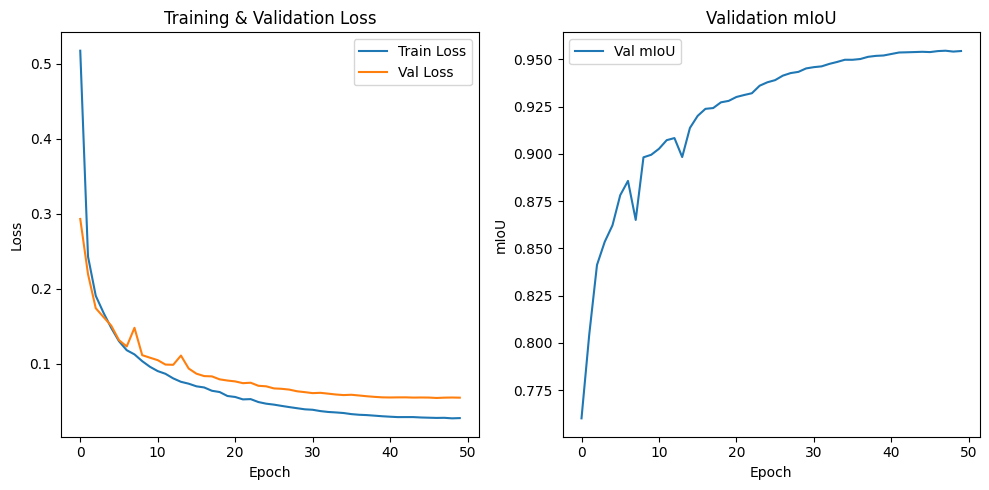

In [18]:
# ===== Loss 그래프 + mIoU 그래프 =====
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")

plt.subplot(1,2,2)
plt.plot(val_ious, label="Val mIoU")
plt.xlabel("Epoch")
plt.ylabel("mIoU")
plt.legend()
plt.title("Validation mIoU")

plt.tight_layout()
plt.savefig("m3_final/graph.png")
plt.show()

# Validation

In [19]:
# ===== Validation set에서 mIoU 평가 =====
def compute_iou(preds, masks, threshold=0.5):
    preds = torch.sigmoid(preds)          # 변경: logits -> prob
    preds = (preds > threshold).float()
    preds = preds.cpu().numpy().astype(int).reshape(-1)
    masks = masks.cpu().numpy().astype(int).reshape(-1)

    cm = confusion_matrix(masks, preds, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    intersection = tp
    union = tp + fp + fn
    iou = intersection / (union + 1e-7)
    return iou


In [20]:
# best_model
best_model = MultiStreamUNet("resnet50").to(device)
best_model.load_state_dict(torch.load("m3_final/best.pth", weights_only=True))
best_model.eval()


# Validation mIoU 계산
ious = []
with torch.no_grad():
    for rgb, nir, masks in tqdm(val_loader, desc="Evaluating mIoU"):
        rgb, nir, masks = rgb.float().to(device), nir.float().to(device), masks.float().to(device)
        # x = torch.cat([rgb, nir], dim=1)  # [B,4,H,W]
        # preds = best_model(x)
        preds = best_model(rgb, nir)
        iou = compute_iou(preds, masks)
        ious.append(iou)

print(f"Validation mIoU of Best Model (by loss): {np.mean(ious):.4f}")

Evaluating mIoU: 100%|██████████| 250/250 [00:37<00:00,  6.63it/s]

Validation mIoU of Best Model (by loss): 0.9567
